In [51]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Creating the functiong that will get the data for us
def get_data(league):
    
    files = [file for file in listdir(f'./../raw_data/{league}')]
    data = pd.DataFrame()


    for file in files:
        df = pd.read_csv(f'./../raw_data/{league}/'+file)
        data = pd.concat([data, df])
    return data

In [4]:
data = get_data(league='turkey')

In [21]:
def feature_engineering(data, b=20):
    '''
    This function creates all the columns that will be needed to create the analysis 
    and return the dataframe with all this changes
    
    b is the number of bins that we want to work with. Our start value for b will be 20.
    '''
        
    # total number of goals = goals from the home team + goals from visiting team
    data['nb_goals']=data['FTHG']+data['FTAG']

    # boolean: true or false regarding whether they were more than 2.5 goals
    data['over_2.5_goals']=data['nb_goals']>2.5

    # boolean: true or false regarding whether they were less than 2.5 goals
    data['under_2.5_goals']=data['nb_goals']<2.5

    # payout of betting on over 2.5 goals: we get 0 if we lose the bet, we get the AvgC if we win the bet (AvgC = market average of the odds)
    data['payout_over_2.5'] = data['over_2.5_goals']*data['AvgC>2.5']

    # payout of betting on under 2.5 goals: we get 0 if we lose the bet, we get the AvgC if we win the bet (AvgC = market average of the odds)
    data['payout_under_2.5'] = data['under_2.5_goals']*data['AvgC<2.5']

    #payout UNDER 2.5 for PINACLE specifically
    data['payout_under_2.5_pinacle'] = data['under_2.5_goals']*data['PC<2.5']

    #payout OVER 2.5 for PINACLE specifically
    data['payout_over_2.5_pinacle'] = data['over_2.5_goals']*data['PC>2.5']

    #payout UNDER 2.5 for 365 specifically
    data['payout_under_2.5_365'] = data['under_2.5_goals']*data['B365C<2.5']

    #payout OVER 2.5 for 365 specifically
    data['payout_over_2.5_365'] = data['over_2.5_goals']*data['B365C>2.5']
    
    #Implied Probability OVER 2.5 goals for overall market (AvgC)
    data['Implied Probability >2.5']=1/data['AvgC>2.5']*100
    
    #Implied Probability UNDER 2.5 goals for overall market (AvgC)
    data['Implied Probability <2.5']=1/data['AvgC<2.5']*100

    #Implied Probability UNDER 2.5 goals for PINACLE
    data['Implied Probability <2.5 pinacle']=1/data['PC<2.5']*100

    #Implied Probability OVER 2.5 goals for PINACLE
    data['Implied Probability >2.5 pinacle']=1/data['PC>2.5']*100

    #Implied Probability UNDER 2.5 goals for 365
    data['Implied Probability <2.5 365']=1/data['B365C<2.5']*100

    #Implied Probability OVER 2.5 goals for 365
    data['Implied Probability >2.5 365']=1/data['B365C>2.5']*100
    
    # Binning the implied probabilities with bins of 10
    b=b
    bins = np.arange(0, 101, int(100/b))
    bins = bins.tolist()
    
    data['binned >2.5'] = pd.cut(data['Implied Probability >2.5'], bins)
    data['binned <2.5'] = pd.cut(data['Implied Probability <2.5'], bins)
    data['binned <2.5 pinacle'] = pd.cut(data['Implied Probability <2.5 pinacle'], bins)
    data['binned >2.5 pinacle'] = pd.cut(data['Implied Probability >2.5 pinacle'], bins)
    data['binned <2.5 365'] = pd.cut(data['Implied Probability <2.5 365'], bins)
    data['binned >2.5 365'] = pd.cut(data['Implied Probability >2.5 365'], bins)
    

    return data

In [22]:
data = feature_engineering(data)

In [23]:
data.columns

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR',
       ...
       'Implied Probability >2.5 365', 'binned', 'binned <2.5',
       'binned <2.5 pinacle', 'binned >2.5 pinacle', 'binned <2.5 365',
       'binned >2.5 365', 'Implied Probability >2.5', 'payout_over_2.5',
       'binned >2.5'],
      dtype='object', length=165)

In [24]:
fdf = data[['Implied Probability','over_2.5_goals','binned','payout']]
fdf_under = data[['Implied Probability <2.5','under_2.5_goals','binned <2.5','payout_under_2.5']]
fdf_under_365 = data[['Implied Probability <2.5 365','under_2.5_goals','binned <2.5 365','payout_under_2.5_365']]
fdf_under_pinacle = data[['Implied Probability <2.5 pinacle','under_2.5_goals','binned <2.5 pinacle','payout_under_2.5_pinacle']]
fdf_over = data[['Implied Probability >2.5','over_2.5_goals','binned >2.5','payout_over_2.5']]
fdf_over_pinacle = data[['Implied Probability >2.5 pinacle','over_2.5_goals','binned >2.5 pinacle','payout_over_2.5_pinacle']]
fdf_over_365 = data[['Implied Probability >2.5 365','over_2.5_goals','binned >2.5 365','payout_over_2.5_365']]

In [28]:
fdf.groupby('binned')['payout'].agg(['count', 'median', 'mean', 'max'])

,count,median,mean,max
binned,,,,
"(0, 5]",0,NaN,NaN,NaN
"(5, 10]",0,NaN,NaN,NaN
"(10, 15]",0,NaN,NaN,NaN
"(15, 20]",0,NaN,NaN,NaN
"(20, 25]",0,NaN,NaN,NaN
"(25, 30]",0,NaN,NaN,NaN
"(30, 35]",0,NaN,NaN,NaN
"(35, 40]",5,0.000,0.502000,2.51
"(40, 45]",46,2.230,1.256739,2.48


In [29]:
#group by BINS of implied probability (whole market) for < 2.5 goals --> series is the number of games
fdf_under.groupby('binned <2.5')['payout_under_2.5'].agg(['count', 'median', 'mean', 'max'])

,count,median,mean,max
binned <2.5,,,,
"(0, 5]",0,NaN,NaN,NaN
"(5, 10]",0,NaN,NaN,NaN
"(10, 15]",0,NaN,NaN,NaN
"(15, 20]",0,NaN,NaN,NaN
"(20, 25]",1,0.00,0.000000,0.00
"(25, 30]",3,0.00,0.000000,0.00
"(30, 35]",14,0.00,0.233571,3.27
"(35, 40]",56,0.00,0.996964,2.85
"(40, 45]",167,0.00,0.760898,2.46


In [30]:
# Same only for 365 bookie
fdf_under_365.groupby('binned <2.5 365')['payout_under_2.5_365'].agg(['count', 'median', 'mean', 'max'])

,count,median,mean,max
binned <2.5 365,,,,
"(0, 5]",0,NaN,NaN,NaN
"(5, 10]",0,NaN,NaN,NaN
"(10, 15]",0,NaN,NaN,NaN
"(15, 20]",0,NaN,NaN,NaN
"(20, 25]",3,0.00,0.000000,0.00
"(25, 30]",7,0.00,0.500000,3.50
"(30, 35]",15,0.00,0.956667,2.87
"(35, 40]",49,0.00,0.744898,2.70
"(40, 45]",148,0.00,0.800000,2.40


In [31]:
fdf_under_pinacle.groupby('binned <2.5 pinacle')['payout_under_2.5_pinacle'].agg(['count', 'median', 'mean', 'max'])

,count,median,mean,max
binned <2.5 pinacle,,,,
"(0, 5]",0,NaN,NaN,NaN
"(5, 10]",0,NaN,NaN,NaN
"(10, 15]",0,NaN,NaN,NaN
"(15, 20]",0,NaN,NaN,NaN
"(20, 25]",2,0.00,0.000000,0.00
"(25, 30]",6,0.00,0.566667,3.40
"(30, 35]",16,0.00,1.102500,3.01
"(35, 40]",79,0.00,0.573418,2.78
"(40, 45]",187,0.00,0.990428,2.49


In [32]:
fdf_over_pinacle.groupby('binned >2.5 pinacle')['payout_over_2.5_pinacle'].agg(['count', 'median', 'mean', 'max'])

,count,median,mean,max
binned >2.5 pinacle,,,,
"(0, 5]",0,NaN,NaN,NaN
"(5, 10]",0,NaN,NaN,NaN
"(10, 15]",0,NaN,NaN,NaN
"(15, 20]",0,NaN,NaN,NaN
"(20, 25]",0,NaN,NaN,NaN
"(25, 30]",0,NaN,NaN,NaN
"(30, 35]",1,0.000,0.000000,0.00
"(35, 40]",12,0.000,1.072500,2.66
"(40, 45]",82,1.115,1.155732,2.47


In [49]:
fdf_under_pinacle[fdf_under_pinacle['binned <2.5 pinacle'].astype(str)=='(45, 50]']['payout_under_2.5_pinacle']

0      0.00
2      2.14
6      2.14
7      2.19
12     2.13
       ... 
263    2.22
272    2.02
275    0.00
279    0.00
291    2.13
Name: payout_under_2.5_pinacle, Length: 329, dtype: float64

<AxesSubplot:ylabel='Count'>

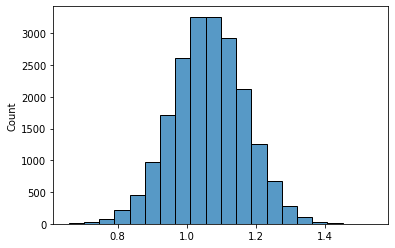

In [53]:
n = 100
N = 20000
means = [fdf_under_pinacle[fdf_under_pinacle['binned <2.5 pinacle'].astype(str)=='(45, 50]']['payout_under_2.5_pinacle'].sample(n, replace=True).mean() for i in range(N)]

sns.histplot(means, bins=20)

In [59]:
mu = fdf_under_pinacle[fdf_under_pinacle['binned <2.5 pinacle'].astype(str)=='(45, 50]']['payout_under_2.5_pinacle'].mean()
sigma = fdf_under_pinacle[fdf_under_pinacle['binned <2.5 pinacle'].astype(str)=='(45, 50]']['payout_under_2.5_pinacle'].std()

In [60]:
from scipy.stats import skew, kurtosis

# $CHALLENGIFY_BEGIN
index_df = ['mean', 'stdev', 'kurtosis', 'skewness']
theory = [mu, sigma/np.sqrt(n), 0, 0]
real_life = [np.mean(means), np.std(means), skew(means), kurtosis(means)]
comparison_df = pd.DataFrame(list(zip(theory,real_life)), 
                             columns = ["CLT Theory","Real Tips"],
                             index = index_df)
round(comparison_df,2)
# $CHALLENGIFY_END

,CLT Theory,Real Tips
mean,1.06,1.06
stdev,0.11,0.11
kurtosis,0.00,-0.03
skewness,0.00,-0.01


In [ ]:
import numpy
import matplotlib.pyplot as plt
 
# number of sample
num = [1, 10, 50, 100] 
# list of sample means
means = [] 
 
# Generating 1, 10, 30, 100 random numbers from -40 to 40
# taking their mean and appending it to list means.
for j in num:
    # Generating seed so that we can get same result
    # every time the loop is run...
    numpy.random.seed(1)
    x = [numpy.mean(
        numpy.random.randint(
            -40, 40, j)) for _i in range(1000)]
    means.append(x)
k = 0
 
# plotting all the means in one figure
fig, ax = plt.subplots(2, 2, figsize =(8, 8))
for i in range(0, 2):
    for j in range(0, 2):
        # Histogram for each x stored in means
        ax[i, j].hist(means[k], 10, density = True)
        ax[i, j].set_title(label = num[k])
        k = k + 1
 plt.show()